# Workflow Outline
This notebook outlines the workflow for finetuning emotion detection. It should be ran in Google Colab with a GPU

## Install & Import modules

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 2.2 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Import data

In [3]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

## Set up data pipeline

In [4]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"

df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

df.head()

,id,split,V,A,D,text,anger,disgust,fear,joy,sadness,surprise
0,1,train,2.29,3.29,2.86,Mortar assault leaves at least 18 dead,22,2,60,0,64,0
1,10,train,3.50,2.88,3.00,Alonso would be happy to retire with three titles,0,0,0,61,24,0
2,100,train,2.88,3.00,3.00,Report criticises US press freedoms,25,24,6,21,13,13
3,1000,train,2.00,3.62,2.75,Terror officials see Al Qaeda chiefs regaining...,13,11,86,0,16,3
4,1001,train,2.80,3.00,3.00,"Ivrea journal: In Italian town, a civics lesso...",0,5,0,3,0,25


In [5]:
# some global variables 
EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [6, 3]

# Load data into numpy
x_text_raw = list(df['text'])
y_ekman_raw = df[EKMAN_EMOTIONS].to_numpy()
y_vad_raw = df[VAD_EMOTIONS].to_numpy()

# Example:
print(x_text_raw[0])
print(y_ekman_raw[0])
print(y_vad_raw[0])
print(len(x_text_raw))

Mortar assault leaves at least 18 dead
[22  2 60  0 64  0]
[2.29 3.29 2.86]
1149


In [43]:
# all VAD values are non-negative
(y_vad_raw < 0).sum(), y_vad_raw.mean(), y_vad_raw.min(), y_vad_raw.max()

(0, 2.9822077168552363, 1.57, 4.33)

In [50]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 
# Note: 'bert-base-uncased' is the name of the checkpoint, this should be consistent in both the tokenizer and the AutoModel

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_text_raw, padding=True, truncation=True, return_tensors="pt")
# Note: padding matches the length of each row, truncation makes sure that the input length isn't too long for the model (256 for bert-base-uncased)

print(encoded_input.keys())
# Note: the keys we want are input_ids and ateention_mask, token_type_ids is for tasks where you want two sequences as input (e.g. Q&A)

print(encoded_input['input_ids'].shape) 
# Note: the width defaults to the longest sentence in our data

# Example:
print(tokenizer.decode(encoded_input["input_ids"][0])) # you can decode it back into text

X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']

y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float)
y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)

# optional: delete df and x_text if the dataset is large

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([1149, 21])
[CLS] mortar assault leaves at least 18 dead [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [51]:
# Normalizing y (subject to change)
y_ekman_tensor = F.normalize(y_ekman_tensor, dim=-1)
# y_vad_tensor = y_vad_tensor - 3
# VAD could be squished into [0, 1] if needed? -> yes
# y_vad_tensor = (y_vad_tensor - 3) * 2 - 1
y_vad_tensor =  F.normalize(y_vad_tensor, dim=-1)

y = torch.concat((y_ekman_tensor, y_vad_tensor), axis=-1)


In [52]:
y_vad_raw[0], y_vad_tensor[0]

(array([2.29, 3.29, 2.86]), tensor([0.4650, 0.6681, 0.5808]))

### Train-val-test split

* split data set into 80-20 train-test
* split train into 50-50 labelling schemes


In [8]:
def train_val_split(X_ids, X_mask, y, ratio):
  n = X_ids.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_ids_train, X_mask_train, y_train = X_ids[perm[:train_size]], X_mask[perm[:train_size]], y[perm[:train_size]]
  X_ids_val, X_mask_val, y_val = X_ids[perm[train_size:]], X_mask[perm[train_size:]], y[perm[train_size:]]

  return X_ids_train, X_mask_train, y_train, X_ids_val, X_mask_val, y_val

In [54]:
# split into train-val
X_ids_train, X_mask_train, y_train, X_ids_test, X_mask_test, y_test = train_val_split(X_input, X_mask, y, ratio=0.8)

# split into two tasks (this is very redundant but makes workflow clearer)
X_ids_ekman, X_mask_ekman, y_ekman, X_ids_vad, X_mask_vad, y_vad = train_val_split(X_ids_train, X_mask_train, y_train, ratio=0.5)

# drop the redundant labels
y_ekman[:, 6:] = torch.zeros_like(y_ekman[:, 6:])
y_vad[:, :6] = torch.zeros_like(y_vad[:, :6])

In [55]:
print(f'number of ekman training points: {len(X_ids_ekman)}')
print(f'number of vad training points: {len(X_ids_vad)}')

number of ekman training points: 459
number of vad training points: 460


In [56]:
y_ekman[0]

tensor([0.0000, 0.0000, 0.2690, 0.0000, 0.7174, 0.6427, 0.0000, 0.0000, 0.0000])

In [58]:
# attach task labels to the two tasks 
task_ekman = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ids_ekman), 1))
task_vad = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_ids_vad), 1))
task_test = torch.tensor([1, 1]).unsqueeze(0).repeat((len(X_ids_test), 1))

# merge ekman and vad back into one train set 
X_ids_train = torch.concat((X_ids_ekman, X_ids_vad), dim=0)
X_mask_train = torch.concat((X_mask_ekman, X_mask_vad), dim=0)
y_train = torch.concat((y_ekman, y_vad), dim=0)
task_train = torch.concat((task_ekman, task_vad), dim=0)

# Example
id = 600
print(X_ids_train[id])
print(X_mask_train[id])
print(y_train[id])
print(task_train[id])

tensor([  101,  2308,  6186,  4501, 12451,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5440, 0.6217, 0.5635])
tensor([0, 1])


In [60]:
# Move everything to device
X_ids_train = X_ids_train.to(DEVICE)
X_mask_train = X_mask_train.to(DEVICE)
y_train = y_train.to(DEVICE)
task_train = task_train.to(DEVICE)

X_ids_test = X_ids_test.to(DEVICE)
X_mask_test = X_mask_test.to(DEVICE)
y_test = y_test.to(DEVICE)
task_test = task_test.to(DEVICE)

### Dataset

In [61]:
class EBAT_dataset(Dataset):
  def __init__(self, X_ids, X_mask, y, task, transform=None):
    self.X_ids = X_ids 
    self.X_mask = X_mask
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]
    self.transform = transform

  def __len__(self):
    return self.X_ids.shape[0]

  def __getitem__(self, idx):
    sample = (self.X_ids[idx], self.X_mask[idx], self.y[idx], self.task[idx])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [62]:
train_dataset = EBAT_dataset(X_ids_train, X_mask_train, y_train, task_train)
test_dataset = EBAT_dataset(X_ids_test, X_mask_test, y_test, task_test)

print(f'total data = {len(X_input)}')
print(f'train set size = {len(train_dataset)}')
print(f'test set size = {len(test_dataset)}')

total data = 1149
train set size = 919
test set size = 230


### DataLoader

In [63]:
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle=True)

print(f'number of batches in training set: {len(train_dataloader)}')
print(f'number of batches in testing set: {len(test_dataloader)}')

# example batch
sample = next(iter(train_dataloader))
X_id, X_mask, y, task = sample

# example single data
print(X_id[0])
print(X_mask[0])
print(y[0])
print(task[0])

number of batches in training set: 92
number of batches in testing set: 23
tensor([  101,  2003,  2378, 15907, 13331,  4520,  3983,  2088,  2501,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.9122, 0.0000, 0.4098, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([1, 0], device='cuda:0')


## Model Definition

In [79]:
class MultiheadNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.ekman_predictor = nn.Linear(768, EMOTION_DIMS[0])
    self.vad_predictor = nn.Linear(768, EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)
    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(pooler_output)
    y_ekman = self.relu(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(pooler_output)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [65]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
net = MultiheadNetwork(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [67]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[4608, 6, 2304, 3]


In [68]:
with torch.no_grad(): # so that gradients are not accumulated
  sample = next(iter(train_dataloader))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)

In [69]:
print(task)

tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], device='cuda:0')


### Loss Function

In [70]:
class custom_MSE(object):
  def __init__(self):
    self.loss = nn.MSELoss()
  
  def __call__(self, y_gt, y_pred) -> torch.tensor:
    '''
    Computes MSE on all emotion labelling schemes

    Returns:
    -----
    losses: 1D tensor with length num_schemes
    '''
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
    s = 0
    for (i, dim) in enumerate(EMOTION_DIMS):
      losses[i] = self.loss(y_gt[:, s:s+dim], y_pred[:, s:s+dim]).mean()
      s += dim
    # avg_loss = torch.norm(losses)
    return losses


# def custom_MSE(y_gt, y_pred, task) -> torch.tensor:
#   '''
#   Computes MSE on all emotion labelling schemes

#   Returns:
#   -----
#   losses: 1D tensor with length num_schemes
#   '''
#   losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float())
#   s = 0
#   for (i, dim) in enumerate(EMOTION_DIMS):
#     toggle = task[i]
#     losses[i] = nn.MSELoss(y_gt[s:s+dim], y_pred[s:s+dim]) * toggle
#     s += dim
#   # avg_loss = torch.norm(losses)
#   return losses

## Training Loop

In [212]:
class TrainingManager():
  def __init__(self, net, train_dataloader, test_dataloader, LEL=False, max_epochs=100):
    self.net = net
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = custom_MSE()

    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-6)

    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'test_loss_ekman': [],
        'test_loss_vad': [],
        'test_loss_avg': [],
        'test_ekman_accuracy': []
    }

    self.max_epochs = max_epochs
    self.num_epochs = 0
  
  def train(self, epochs):
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0
      ekman_count = 0
      vad_count = 0

      for X_id, X_mask, y, task in tqdm(self.train_dataloader):
        self.optimizer.zero_grad()

        y_pred = net(X_id, X_mask, task)

        train_loss = self.criterion(y_pred, y, task)

        loss = torch.norm(train_loss)

        loss.backward()

        self.optimizer.step()

        # storing minibatch results
        total_loss_ekman += train_loss[0].item()
        total_loss_vad += train_loss[1].item()
        total_loss_avg += torch.norm(train_loss).item()

        ekman_count += task[:, 0].sum()
        vad_count += task[:, 1].sum()

      # storing epoch results
      test_loss_ekman, test_loss_vad, test_loss_avg, test_ekman_accuracy = self.evaluate(self.test_dataloader)

      total_loss_ekman /= len(self.train_dataloader)
      total_loss_vad /= len(self.train_dataloader)
      total_loss_avg /= len(self.train_dataloader)
    
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['test_loss_ekman'].append(test_loss_ekman)
      self.history['test_loss_vad'].append(test_loss_vad)
      self.history['test_loss_avg'].append(test_loss_avg)
      self.history['test_ekman_accuracy'].append(test_ekman_accuracy)

      print(f'Epoch {e+1}: train_loss = {total_loss_avg:.3f}, test_loss = {test_loss_avg:.3f}')
      print(f'Epoch {e+1}: train_ekman = {total_loss_ekman:.3f}, train_vad = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: test_ekman = {test_loss_ekman:.3f}, test_vad = {test_loss_vad:.3f}')
      print(f'Epoch {e+1}: test_ekman_accuracy = {test_ekman_accuracy:.3f}')

      self.num_epochs += 1
  
  def evaluate(self, dataloader=None):
    if dataloader == None:
      dataloader = self.test_dataloader
    with torch.no_grad():
      total_loss_avg = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      for X_id, X_mask, y, task in tqdm(dataloader):
        y_pred = net(X_id, X_mask, task)

        loss = self.criterion(y_pred, y, task)

        # judge performance only based on Ekman = for training it evaluates only on train data with Ekman labels
        # for testing it plays no role (all samples are evaluated)
        ekman_mask = task[:, 0].nonzero().squeeze()
        y_top = torch.argmax(y[ekman_mask, 0: 6], dim=-1)
        y_top_pred = torch.argmax(y_pred[ekman_mask, 0:6], dim=-1)

        ekman_top1_correct += torch.where(y_top == y_top_pred, torch.ones_like(y_top), torch.zeros_like(y_top)).sum()

        total_loss_ekman += loss[0].item()
        total_loss_vad += loss[1].item()
        total_loss_avg += torch.norm(loss).item()
    
    total_loss_ekman /= len(dataloader)
    total_loss_vad /= len(dataloader)
    total_loss_avg /= len(dataloader)
    ekman_accuracy = ekman_top1_correct.item() / len(dataloader.dataset)

    return total_loss_ekman, total_loss_vad, total_loss_avg, ekman_accuracy

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Avg loss')
    plt.plot(self.history['train_loss_avg'], label='train')
    plt.plot(self.history['test_loss_avg'], label='test')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['test_loss_ekman'], label='test')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['test_loss_vad'], label='test')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['test_ekman_accuracy'], label='train')
    plt.legend()

    plt.show()


In [214]:
net = MultiheadNetwork(bert)
net.to(DEVICE)
training_manager = TrainingManager(net, train_dataloader, test_dataloader)

In [216]:
training_manager.evaluate()

  0%|          | 0/23 [00:00<?, ?it/s]

(0.17048619622769562,
 0.1792020830123321,
 0.24778462816839633,
 0.09130434782608696)

In [217]:
training_manager.train(epochs=150)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1: train_loss = 0.235, test_loss = 0.227
Epoch 1: train_ekman = 0.165, train_vad = 0.166
Epoch 1: test_ekman = 0.162, test_vad = 0.158
Epoch 1: test_ekman_accuracy = 0.096


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2: train_loss = 0.215, test_loss = 0.208
Epoch 2: train_ekman = 0.156, train_vad = 0.146
Epoch 2: test_ekman = 0.154, test_vad = 0.138
Epoch 2: test_ekman_accuracy = 0.096


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3: train_loss = nan, test_loss = nan
Epoch 3: train_ekman = nan, train_vad = nan
Epoch 3: test_ekman = nan, test_vad = nan
Epoch 3: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4: train_loss = nan, test_loss = nan
Epoch 4: train_ekman = nan, train_vad = nan
Epoch 4: test_ekman = nan, test_vad = nan
Epoch 4: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5: train_loss = nan, test_loss = nan
Epoch 5: train_ekman = nan, train_vad = nan
Epoch 5: test_ekman = nan, test_vad = nan
Epoch 5: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6: train_loss = nan, test_loss = nan
Epoch 6: train_ekman = nan, train_vad = nan
Epoch 6: test_ekman = nan, test_vad = nan
Epoch 6: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7: train_loss = nan, test_loss = nan
Epoch 7: train_ekman = nan, train_vad = nan
Epoch 7: test_ekman = nan, test_vad = nan
Epoch 7: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8: train_loss = nan, test_loss = nan
Epoch 8: train_ekman = nan, train_vad = nan
Epoch 8: test_ekman = nan, test_vad = nan
Epoch 8: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9: train_loss = nan, test_loss = nan
Epoch 9: train_ekman = nan, train_vad = nan
Epoch 9: test_ekman = nan, test_vad = nan
Epoch 9: test_ekman_accuracy = 0.052


  0%|          | 0/92 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

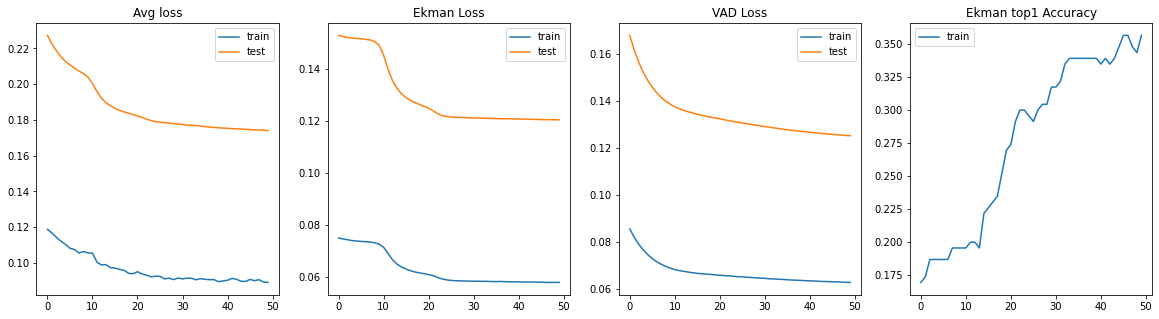

In [74]:
# 50-50 data split
training_manager.plot_history()

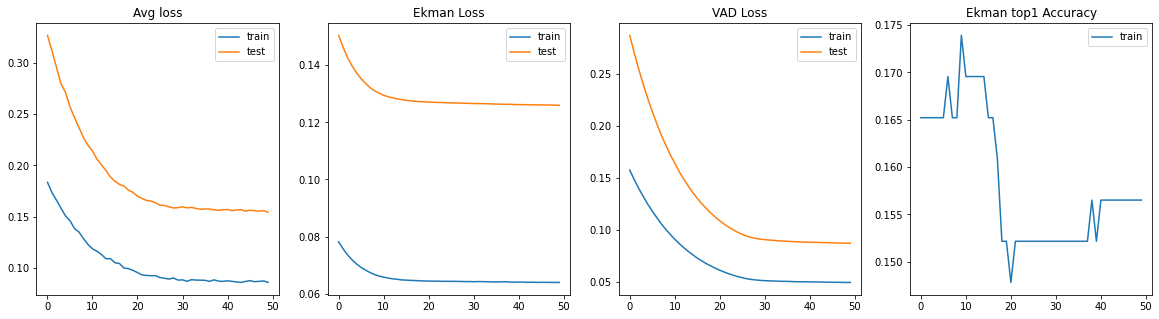

In [31]:
# 50-50 data split (old normalization)
training_manager.plot_history()

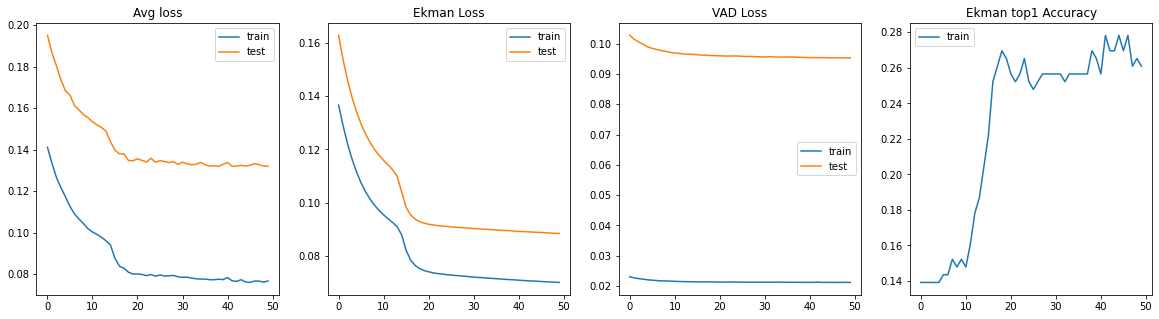

In [ ]:
#80-20 split
training_manager.plot_history()

## Qualitative Evaluation

In [84]:
results_df = pd.DataFrame([], columns = EKMAN_EMOTIONS + VAD_EMOTIONS)
with torch.no_grad():
  sample = next(iter(test_dataloader))
  X_id, X_mask, y, task = sample
  y_pred = net(X_id, X_mask, task)
  

  for i in range(len(X_id)):
    sent = tokenizer.decode(X_id[i], skip_special_tokens=True)
    row_gt = {heading: val for heading, val, in zip(results_df.columns, y[i].cpu().numpy())}
    row_pred = {heading: val for heading, val, in zip(results_df.columns, y_pred[i].cpu().numpy())}
    results_df = results_df.append(pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}']))
    print(sent)
results_df

north africa feared as staging ground for terror
france ends toxic alert at canadian embassy in paris
life in gaza steadily worsens
' alpha dog'misses the point
trains crash near thai resort town
gronholm takes a commanding lead
for women, aspirin a day could keep stroke away
injured marathon winner leaves hospital
ottawa must redefine'terror '
canete wins inaugural joburg open


<ipython-input-84-5bdccd6c6c11>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}']))
<ipython-input-84-5bdccd6c6c11>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}']))
<ipython-input-84-5bdccd6c6c11>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}']))
<ipython-input-84-5bdccd6c6c11>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.a

,anger,disgust,fear,joy,sadness,surprise,V,A,D
gt 0,0.190426,0.179846,0.930969,0.000000,0.243322,0.074054,0.433936,0.723227,0.537254
pred 0,0.000000,0.053214,0.157472,0.375176,0.408341,0.000000,0.597060,0.598464,0.527449
gt 1,0.000000,0.000000,0.697355,0.677984,0.000000,0.232452,0.543915,0.593362,0.593362
pred 1,0.000000,0.062644,0.344186,0.365755,0.468627,0.000000,0.518983,0.678986,0.644107
gt 2,0.188112,0.143851,0.586468,0.000000,0.774581,0.000000,0.485662,0.618115,0.618115
pred 2,0.000000,0.124121,0.447856,0.382070,0.485680,0.000000,0.542641,0.567063,0.712964
gt 3,0.000000,0.120289,0.000000,0.000000,0.681638,0.721734,0.547238,0.577528,0.605799
pred 3,0.000000,0.089944,0.132436,0.406726,0.195369,0.000000,0.485214,0.537926,0.691909
gt 4,0.018221,0.000000,0.564851,0.000000,0.819946,0.091105,0.481014,0.732974,0.481014
pred 4,0.000000,0.095852,0.331316,0.446028,0.463219,0.000000,0.592201,0.636391,0.668504


# Label Embedding Layer (LEL)
- combines multiple heads into a single prediction layer
- after training, LEL encodes the relationships between label spaces

## Model Definition

In [171]:
class LEL_Network(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    # label embedding layer
    self.LEL = nn.Linear(768, EMOTION_DIMS[0]+EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)

    y =  self.LEL(pooler_output)
    y = self.relu(y)

    # if different activation func for ekman and VAD
    # filtering would need to be added
    return y

In [91]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [172]:
net = LEL_Network(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [173]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[6912, 9]


In [191]:
with torch.no_grad(): # so that gradients are not accumulated
  sample = next(iter(train_dataloader))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)
  print('Example output prediction of LEL')
  print(y_pred, y_pred.shape)

Example output prediction of LEL
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0796, 0.0766, 0.0448],
        [0.0000, 0.0000, 0.0790, 0.0000, 0.0000, 0.0000, 0.1375, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0380, 0.0619, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0807, 0.0613, 0.1566, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0316, 0.1444, 0.0000],
        [0.0000, 0.0000, 0.1842, 0.0000, 0.0000, 0.0000, 0.1013, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0755, 0.0705, 0.1259, 0.0032],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0982, 0.0872, 0.1130, 0.0237],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0868, 0.0602, 0.0000],
        [0.0029, 0.0000, 0.5091, 0.0515, 0.0000, 0.0000, 0.1748, 0.0000, 0.2002]],
       device='cuda:0') torch.Size([10, 9])


### Loss Function

In [213]:
class custom_MSE(object):
  def __init__(self):
    self.loss = nn.MSELoss()
  
  def __call__(self, y_gt, y_pred, task) -> torch.tensor:
    '''
    Computes MSE on all emotion labelling schemes

    Returns:
    -----
    losses: 1D tensor with length num_schemes
    '''
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
    # the predictions are no longer zero for labels unrelated to task
    # we have to use a mask to only process the loss on task-specific examples
    masks = (task[:, 0].nonzero().squeeze(), task[:, 1].nonzero().squeeze())
    
    s = 0
    # here we extract losses from the appropriate section of the label space
    for (i, dim) in enumerate(EMOTION_DIMS):
      losses[i] = self.loss(y_gt[masks[i], s:s+dim], y_pred[masks[i], s:s+dim]).mean()
      s += dim
    # avg_loss = torch.norm(losses)
    return losses

In [195]:
net_LEL = Multihead_LEL_Network(bert)
net_LEL.to(DEVICE)
training_manager = TrainingManager(net_LEL, train_dataloader, test_dataloader)

In [196]:
training_manager.evaluate()

  0%|          | 0/23 [00:00<?, ?it/s]

(0.16294515327267026,
 0.2671109995116358,
 0.3129477630490842,
 0.09130434782608696)

In [188]:
training_manager.train(epochs=100)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

> <ipython-input-185-2f2e7d509581>(87)evaluate()
     84       for X_id, X_mask, y, task in tqdm(dataloader):
     85         y_pred = net(X_id, X_mask, task)
     86         ipdb.set_trace(context=6)
---> 87         loss = self.criterion(y_pred, y, task)
     88 
     89         # judge performance only based on Ekman labels

ipdb> next
> <ipython-input-185-2f2e7d509581>(90)evaluate()
     87         loss = self.criterion(y_pred, y, task)
     88 
     89         # judge performance only based on Ekman labels
---> 90         ekman_mask = task[:, 0].nonzero().squeeze()
     91         y_top = torch.argmax(y[ekman_mask, 0: 6], dim=-1)
     92         y_top_pred = torch.argmax(y_pred[ekman_mask, 0:6], dim=-1)

ipdb> task
tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]], device='cuda:0')
--KeyboardInterrupt--
ipdb> q


BdbQuit: ignored

> /usr/lib/python3.9/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

--KeyboardInterrupt--
ipdb> q


In [ ]:
from sklearn.manifold import TSNE

In [174]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 37.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.11.0 which is incompatible.


In [189]:
%pdb off

Automatic pdb calling has been turned OFF
